## Travel Pattern Analysis and Hypothesis Testing  

### Objective  
In this section of the project, I analyze **Google Maps Timeline data collected between February and April** to understand **personal travel behavior** across different days of the week and hours of the day.  
The goal is to uncover recurring patterns and evaluate the hypothesis:

> **“I travel more on weekdays compared to weekends.”**

---

### What I Am Doing  

1. **Exploratory Data Analysis (EDA)**  
   - Aggregate daily travel data to calculate total and average:  
     - Distance traveled  
     - Duration of trips  
     - Number of trips per day  
   - Visualize these metrics by day of the week to detect trends.  

2. **Time-Based Pattern Discovery**  
   - Use a **heatmap** to visualize when trips occur, grouped by day and hour.  
   - This helps identify common travel times (e.g., commute windows or weekend outings).  

3. **Hypothesis Testing**  
   - **Null Hypothesis (H₀)** The mean daily travel distance on **weekdays** is **equal to** the mean daily travel distance on **weekends**.  
   - **Alternative Hypothesis (H₁)** The mean daily travel distance on **weekdays** is **greater than** the mean daily travel distance on **weekends**.  
   - Compare average daily travel distances on weekdays vs. weekends.  
   - Use a **unequal variances t-test** to determine whether the observed differences are statistically significant.  

---

### Key Findings  

- Weekday and weekend travel distances were very similar on average (dataset: Feb – Apr).  
- The t-test indicates **no significant difference** between the two groups.  
- Heatmaps revealed **commute-like patterns** on weekdays with morning and evening peaks, while weekends showed fewer and more irregular trips.  

# Load Data

In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")

with open('/Users/efeyagizkilickaya/Downloads/temiz data.txt', 'r', encoding='utf-8') as f:
    raw_data = f.read()

raw_data = "[" + raw_data.strip().rstrip(",") + "]"
data = json.loads(raw_data)

print("Total records loaded:", len(data))


Total records loaded: 312


# Parse and Normalize the Data

In [2]:
from dateutil.parser import parse, ParserError
import pandas as pd


def parse_record(record):
    if "activity" in record:
        event_type = "activity"
        try:
            distance = float(record["activity"].get("distanceMeters", 0))
        except:
            distance = np.nan
        mode = record["activity"].get("topCandidate", {}).get("type", None)
    elif "visit" in record:
        event_type = "visit"
        distance = np.nan  # Visits do not have distance info
        mode = record["visit"].get("topCandidate", {}).get("semanticType", None)
    else:
        event_type = "unknown"
        distance = np.nan
        mode = None

    start = record.get("startTime")
    end = record.get("endTime")
    
    return {
        'startTime': start,
        'endTime': end,
        'event_type': event_type,
        'distanceMeters': distance,
        'mode': mode
    }

parsed_data = [parse_record(rec) for rec in data]
df = pd.DataFrame(parsed_data)
def safe_parse(dt_str):
    try:
        return parse(dt_str)
    except ParserError as e:
        if "day is out of range for month" in str(e):
            if dt_str.startswith("2025-02-29"):
                dt_str_fixed = dt_str.replace("2025-02-29", "2025-02-28")
                try:
                    return parse(dt_str_fixed)
                except:
                    return pd.NaT
        return pd.NaT

df['startTime'] = df['startTime'].apply(safe_parse)
df['endTime'] = df['endTime'].apply(safe_parse)

print(df[['startTime', 'endTime']].head())
print("DataFrame shape:", df.shape)
df.head()


                         startTime                          endTime
0 2025-02-19 07:41:18.999000+03:00 2025-02-19 07:45:26.069000+03:00
1 2025-02-19 07:45:26.069000+03:00 2025-02-19 08:33:12.999000+03:00
2 2025-02-19 08:33:12.999000+03:00 2025-02-19 10:11:26.519000+03:00
3 2025-02-19 08:33:12.999000+03:00 2025-02-19 09:32:46.496000+03:00
4 2025-02-19 10:11:26.519000+03:00 2025-02-19 10:51:19.692000+03:00
DataFrame shape: (312, 5)


,startTime,endTime,event_type,distanceMeters,mode
0,2025-02-19 07:41:18.999000+03:00,2025-02-19 07:45:26.069000+03:00,visit,NaN,Inferred Home
1,2025-02-19 07:45:26.069000+03:00,2025-02-19 08:33:12.999000+03:00,activity,31160.0,in passenger vehicle
2,2025-02-19 08:33:12.999000+03:00,2025-02-19 10:11:26.519000+03:00,visit,NaN,Unknown
3,2025-02-19 08:33:12.999000+03:00,2025-02-19 09:32:46.496000+03:00,visit,NaN,Unknown
4,2025-02-19 10:11:26.519000+03:00,2025-02-19 10:51:19.692000+03:00,activity,31040.0,in passenger vehicle


#  Data Preprocessing

In [3]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

df['duration_minutes'] = (df['endTime'] - df['startTime']).dt.total_seconds() / 60.0

# Extract the date and the day name from the start time
df['date'] = df['startTime'].dt.date
df['day_of_week'] = df['startTime'].dt.day_name()

# Drop the bad row
df = df[df['duration_minutes'] >= 0].copy()

df.head()


,startTime,endTime,event_type,distanceMeters,mode,duration_minutes,date,day_of_week
0,2025-02-19 07:41:18.999000+03:00,2025-02-19 07:45:26.069000+03:00,visit,NaN,Inferred Home,4.117833,2025-02-19,Wednesday
1,2025-02-19 07:45:26.069000+03:00,2025-02-19 08:33:12.999000+03:00,activity,31160.0,in passenger vehicle,47.782167,2025-02-19,Wednesday
2,2025-02-19 08:33:12.999000+03:00,2025-02-19 10:11:26.519000+03:00,visit,NaN,Unknown,98.225333,2025-02-19,Wednesday
3,2025-02-19 08:33:12.999000+03:00,2025-02-19 09:32:46.496000+03:00,visit,NaN,Unknown,59.558283,2025-02-19,Wednesday
4,2025-02-19 10:11:26.519000+03:00,2025-02-19 10:51:19.692000+03:00,activity,31040.0,in passenger vehicle,39.886217,2025-02-19,Wednesday


# Exploratory Data Analysis

In [4]:
activity_df = df[df['event_type'] == "activity"].copy()

# Optional: Convert distance from meters to kilometers
activity_df['distance_km'] = activity_df['distanceMeters'] / 1000.0

# Group by date to calculate total distance, total duration, and trip count per day
daily_summary = activity_df.groupby('date').agg({
    'distanceMeters': 'sum',
    'duration_minutes': 'sum',
    'event_type': 'count'
}).rename(columns={'event_type': 'trip_count'}).reset_index()

# Convert date back to datetime and extract the day name
daily_summary['date'] = pd.to_datetime(daily_summary['date'])
daily_summary['day_of_week'] = daily_summary['date'].dt.day_name()

print(daily_summary.head())


        date  distanceMeters  duration_minutes  trip_count day_of_week
0 2025-02-19         80169.0        181.866933           8   Wednesday
1 2025-02-21         64692.0        106.570883           2      Friday
2 2025-02-22         64650.0        101.108500           2    Saturday
3 2025-02-23         64116.0        129.691600           2      Sunday
4 2025-02-25         76490.0        165.408467           6     Tuesday


# Hypothesis Testing

- **Null Hypothesis (H₀)**  
  The mean daily travel distance on **weekdays** is **equal to** the mean daily travel distance on **weekends**.

- **Alternative Hypothesis (H₁)**  
  The mean daily travel distance on **weekdays** is **greater than** the mean daily travel distance on **weekends**.  
  *(one-tailed unequal variances t-test, α = 0.05)*



In this section, I distinguish between weekend and weekday data by creating a boolean column (`is_weekend`) where Saturday and Sunday are marked as weekend days.



In [5]:
# Create a boolean column for weekend days
daily_summary['is_weekend'] = daily_summary['day_of_week'].isin(['Saturday', 'Sunday'])

# Separate the total daily distances into weekdays and weekends
weekday_distances = daily_summary[~daily_summary['is_weekend']]['distanceMeters']
weekend_distances = daily_summary[daily_summary['is_weekend']]['distanceMeters']

print("Average weekday distance (meters):", weekday_distances.mean())
print("Average weekend distance (meters):", weekend_distances.mean())

# Perform t-test
t_stat, p_val = stats.ttest_ind(weekday_distances, weekend_distances, equal_var=False)
print("\nT-test results:")
print("t-statistic =", t_stat)
print("p-value =", p_val)

# For a one-tailed test
one_tailed_p = p_val / 2 if t_stat > 0 else 1 - p_val / 2
print("One-tailed p-value =", one_tailed_p)


Average weekday distance (meters): 59732.90909090909
Average weekend distance (meters): 55939.083333333336

T-test results:
t-statistic = 0.426820044347083
p-value = 0.6736275846004718
One-tailed p-value = 0.3368137923002359


## Hypothesis Results (Weekday vs Weekend Travel)

I compared the **average total travel distance** between weekdays and weekends using a **unequal variances t-test**).

The test produced a **t-statistic of 0.4268** and a **two-tailed p-value of 0.6736**. Even on a one-tailed basis (p ≈ 0.3368), the result is well above the α = 0.05 threshold, so I **fail to reject the null hypothesis**—there is no statistically significant evidence that I travel farther on weekdays than on weekends.

> Although the point estimate suggests I travel **≈ 3.9 km more on weekdays (about 7 %)**, this difference is **not statistically significant** given the variability in the data.

---

### Test Results  

| Metric | Weekdays | Weekends |
|--------|----------|----------|
| **Average distance (m)** | **59732** | **55 939.08** |

- **t-statistic:** 0.4268  
- **p-value (two-tailed):** 0.6736  
- **p-value (one-tailed):** 0.3368  

### Explanation  

Because the **one-tailed p-value = 0.337 > 0.05**, I **fail to reject H₀**.  
The data do not provide strong evidence of a meaningful difference in travel distance between weekdays and weekends; the observed 7 % gap can easily be attributed to random variation in this sample.


# Average Daily Distance by Day of Week

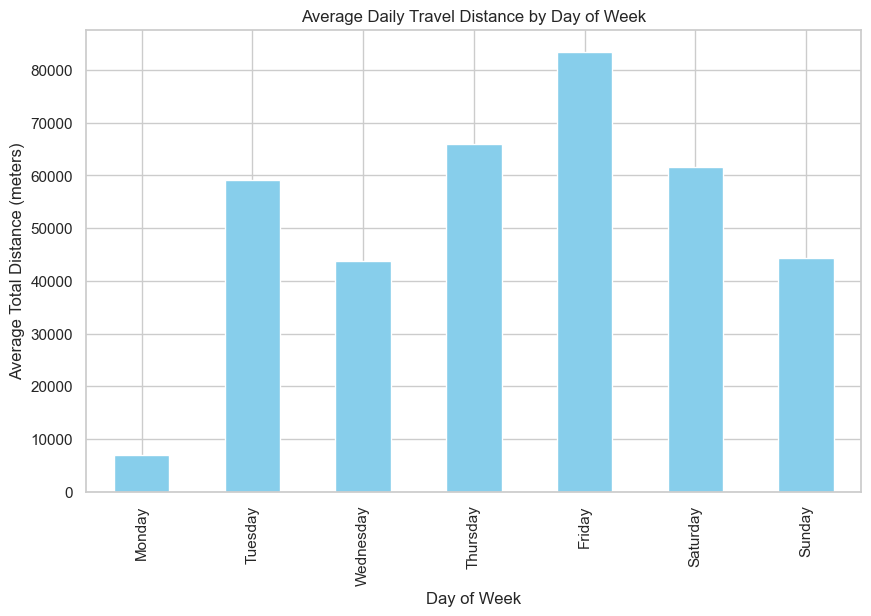

In [6]:
avg_distance_by_day = daily_summary.groupby('day_of_week')['distanceMeters'].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.figure(figsize=(10, 6))
avg_distance_by_day.plot(kind='bar', color='skyblue')
plt.title('Average Daily Travel Distance by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Total Distance (meters)')
plt.show()


# Travel Patterns

## Temporal Travel-Behavior Analysis  

In this section I examine overall travel patterns using:

1. **Daily Travel Metrics** – totals & averages of distance, duration and trip counts for each day-of-week.  
2. **Trip-count Heatmap** – frequency of trip *starts* by day and hour.

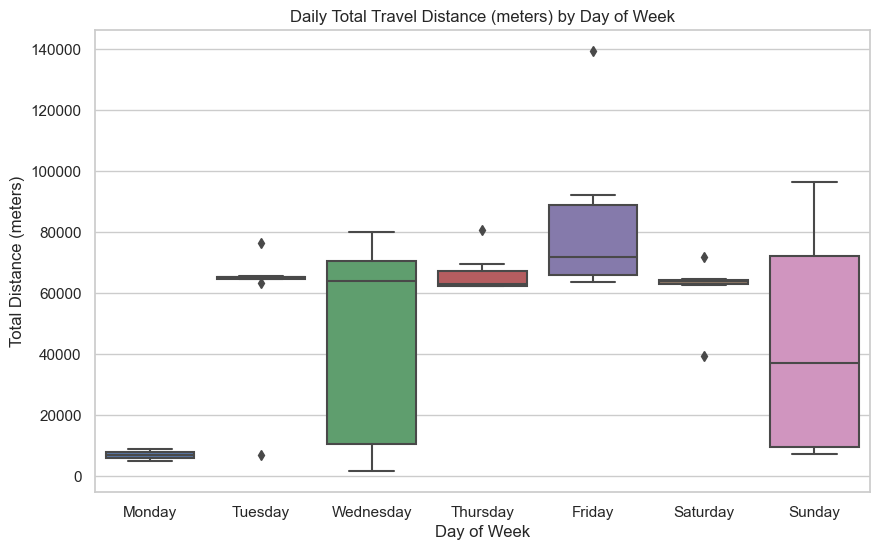

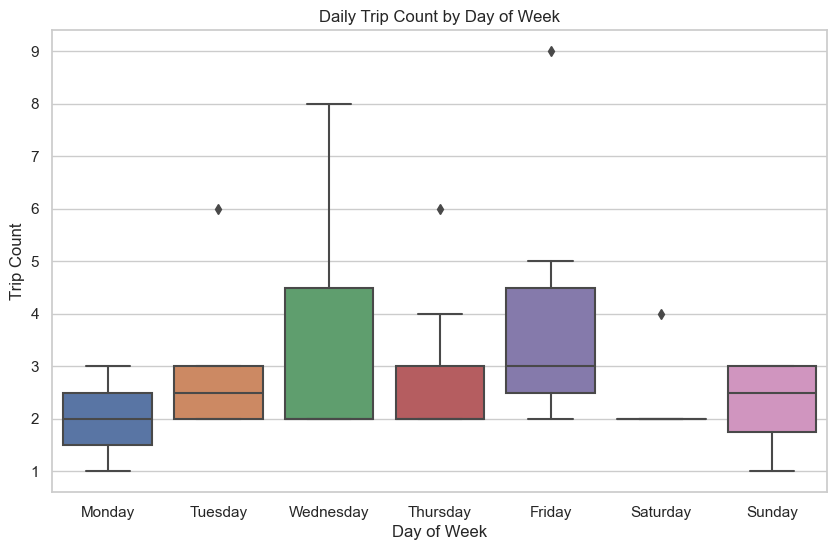

In [7]:
# Boxplot of total daily travel distance (in meters) by day
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='distanceMeters', data=daily_summary,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title('Daily Total Travel Distance (meters) by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Distance (meters)')
plt.show()

# Boxplot of daily trip count by day
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='trip_count', data=daily_summary,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title('Daily Trip Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Trip Count')
plt.show()


Daily Travel Patterns by Day of Week:
             total_distance  avg_distance  total_duration  avg_duration  \
day_of_week                                                               
Monday              13789.0   3447.250000       70.007450     17.501863   
Tuesday            472676.0  20551.130435     1801.942117     78.345309   
Wednesday          306992.0  12279.680000      541.414950     21.656598   
Thursday           593451.0  23738.040000     1008.631250     40.345250   
Friday             584278.0  20867.071429      967.580717     34.556454   
Saturday           493595.0  27421.944444      849.170183     47.176121   
Sunday             177674.0  19741.555556      312.372350     34.708039   

             trip_count  
day_of_week              
Monday                4  
Tuesday              23  
Wednesday            25  
Thursday             25  
Friday               28  
Saturday             18  
Sunday                9  


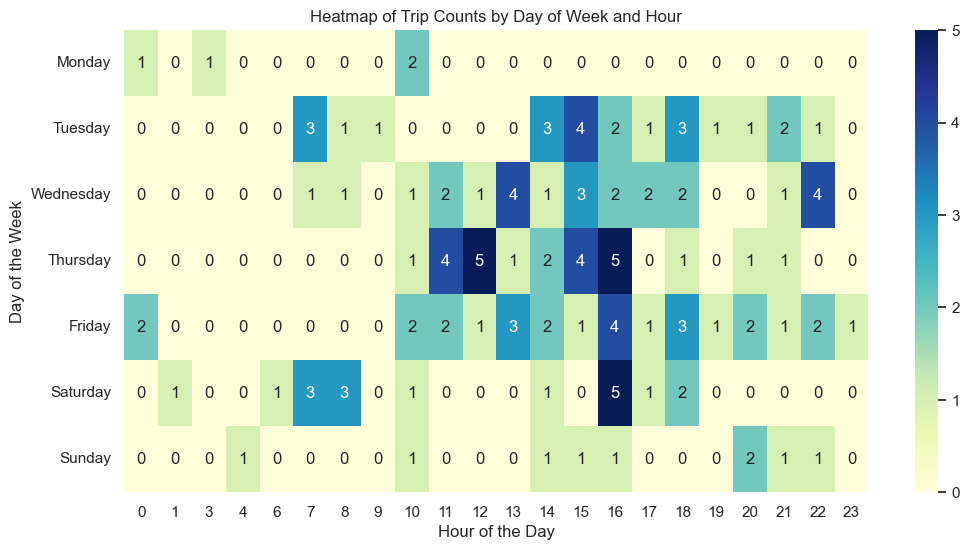

In [8]:
# a. Aggregate daily travel metrics by day-of-week
daily_patterns = activity_df.groupby('day_of_week').agg(
    total_distance = pd.NamedAgg(column='distanceMeters', aggfunc='sum'),
    avg_distance = pd.NamedAgg(column='distanceMeters', aggfunc='mean'),
    total_duration = pd.NamedAgg(column='duration_minutes', aggfunc='sum'),
    avg_duration = pd.NamedAgg(column='duration_minutes', aggfunc='mean'),
    trip_count = pd.NamedAgg(column='distanceMeters', aggfunc='count')
).reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

print("Daily Travel Patterns by Day of Week:")
print(daily_patterns)

activity_df['hour'] = activity_df['startTime'].dt.hour

# Group by day and hour: count number of trips in each time slot.
heatmap_data = activity_df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reorder the days of the week
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(ordered_days)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt="d")
plt.title("Heatmap of Trip Counts by Day of Week and Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()


### Key Insights (from my data)

**Daily metrics**

- **Thursday and Friday** post the **largest total travel distances** of the week, pointing to regular long commutes, off-campus errands, or city trips.
- **Saturday** is dominated by **a few long-distance rides**: it has the **highest average trip distance** but fewer trips overall, likely reflecting weekend outings or visits to family.
- **Monday** shows the **lowest overall activity**, with only 4 trips across the entire dataset—suggesting it’s typically a stay-at-home or study-from-home day.
- **Sunday** also reflects **low travel frequency**, with only 9 trips logged in total. However, the **average distance per trip is quite high (~19.7 km)**, indicating that while trips are fewer, they are relatively long—possibly returning from weekend plans or family visits before the week begins.

**Heatmap patterns**

- Weekdays show clear **commute peaks** at **07:00–09:00** and **15:00–18:00**, especially from **Tuesday through Friday**, matching a typical university schedule.
- **Weekends begin later in the day**, with most movement happening after **10:00 AM**, and Sunday in particular shows **the lowest overall activity**, with scattered and irregular travel patterns.

**Why it matters**

- Helps identify my **regular commuting windows**, which is useful for scheduling meetings, shuttle rides, or study sessions.
- Shows how **weekend vs. weekday behaviour differs**, allowing me to better manage my routine, rest, and energy levels.
- Provides structured **temporal features** (like day-of-week and peak hours) that are valuable for building **predictive models** on travel habits or future movement.
